In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import seaborn as sns  #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링
import plotly.express as px

import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit

**데이터 불러오기**

In [0]:
train = pd.read_csv('/content/drive/My Drive/Data_Science/Compas/화재예측/PJT002_train.csv')
test = pd.read_csv('/content/drive/My Drive/Data_Science/Compas/화재예측/PJT002_test.csv')
valid = pd.read_csv('/content/drive/My Drive/Data_Science/Compas/화재예측/PJT002_validation.csv')
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Compas/화재예측/PJT002_submission.csv')
codebook = pd.read_excel('/content/drive/My Drive/Data_Science/Compas/화재예측/PJT002_codebook.xls')

# EDA

In [0]:
train.head()

,dt_of_fr,fr_yn,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,ttl_dwn_flr,bldng_us_clssfctn,tmprtr,prcpttn,wnd_spd,wnd_drctn,hmdt,gas_engry_us_201401,ele_engry_us_201401,gas_engry_us_201402,ele_engry_us_201402,gas_engry_us_201403,ele_engry_us_201403,gas_engry_us_201404,ele_engry_us_201404,gas_engry_us_201405,ele_engry_us_201405,gas_engry_us_201406,ele_engry_us_201406,gas_engry_us_201407,ele_engry_us_201407,gas_engry_us_201408,ele_engry_us_201408,gas_engry_us_201409,ele_engry_us_201409,gas_engry_us_201410,ele_engry_us_201410,gas_engry_us_201411,ele_engry_us_201411,gas_engry_us_201412,...,lw_13101211,lw_13101310,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,jmk,id,rgnl_ar_nm,rgnl_ar_nm2,lnd_us_sttn_nm,rd_sd_nm,emd_nm,hm_cnt,fr_sttn_dstnc,bldng_ar_prc,fr_wthr_fclt_dstnc,fr_mn_cnt,mlt_us_yn,cctv_dstnc,fr_wthr_fclt_in_100m,cctv_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn
0,2017-10-20 05:54,Y,단독주택,블록구조,3,69.42,69.42,0.0,1977,1.0,0.0,주거용,10.7,NaN,0.9,200.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,106536,자연녹지지역,지정되지않음,단독,세로한면(불),경상남도 창녕군 창녕읍,17360.0,4547,NaN,133,137.0,N,112,0,0,1891,29231,11322,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-30 08:26,N,NaN,NaN,3,46.29,46.29,0.0,NaN,1.0,0.0,NaN,19.5,NaN,0.5,20.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,86366,계획관리지역,지정되지않음,단독,세로한면(가),경상남도 의령군 가례면,1791.0,6388,122581.0,489,85.0,N,818,0,0,4533,20480,3369,7727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-10-30 14:57,Y,공동주택,철근콘크리트구조,1,583.80,2516.76,1446.0,2.00011e+07,5.0,0.0,주거용,15.5,NaN,2.0,90.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,답,107560,제2종일반주거지역,지정되지않음,연립,중로한면,경상남도 창녕군 창녕읍,17285.0,3340,618105.0,143,137.0,N,165,0,0,277,31197,12451,72,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-06-14 05:23,N,단독주택,일반목구조,2,48.92,48.92,0.0,1936,1.0,0.0,주거용,20.6,NaN,0.4,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,97550,제1종일반주거지역,지정되지않음,단독,세로한면(불),경상남도 창원시의창구 대산면,7327.0,179,719542.0,1585,176.0,N,131,0,0,438,4270,407,508,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-22 05:38,N,NaN,NaN,2,0.00,0.00,0.0,NaN,NaN,NaN,NaN,12.7,NaN,0.6,360.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,임,130501,자연환경보전지역,지정되지않음,자연림,세로한면(불),경상남도 창녕군 창녕읍,17278.0,4822,NaN,603,137.0,N,686,0,0,1702,29778,12487,707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train.shape,valid.shape, test.shape 

((59199, 180), (6898, 180), (2957, 180))

**범주형 변수와 연속형 변수 리스트 생성**

In [0]:
# 숫자인데 카테고리인 컬럼
train.wnd_drctn = train.wnd_drctn.astype('object')

cate_col = []
for col in train.columns:
  if train[col].dtype == 'object':
    cate_col.append(col)

numeric_col = list(set(list(train.columns)) - set(cate_col))

# 참고할 내용

중요변수: 건물의 층 면적, 땅 면적, 건물 수, 면적 대비 가격

# 1. Target variable(fr_yn: 화재 여부)

In [0]:
# 분석을 위해 화재 여부를 0,1로 변경
train['fr_yn'] = np.where(train['fr_yn']=='Y', 1 ,0) 
valid['fr_yn'] = np.where(valid['fr_yn']=='Y', 1 ,0)

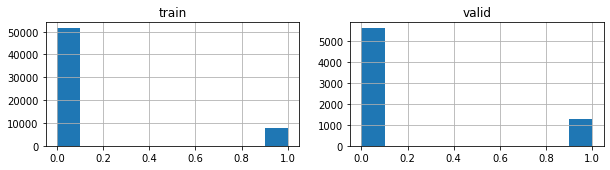

In [0]:
# 타겟 변수의 분포 확인
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
train.fr_yn.hist(ax=ax1, figsize=(10,5))
valid.fr_yn.hist(ax=ax2, figsize=(10,5))
ax1.set_title('train')
ax2.set_title('valid')

plt.show()

- 약 5:1 비율로 Imbalanced data

**대책** 

1) Over / Under sampling: 

>  훈련 데이터가 많지 않으므로 Under sampling은 정보 손실의 위험이 크고, Over sampling은 fr_yn=1에 과적합되더라도 해볼만 함

2) LGBM, Xgb 등의 파라미터 사용 *(최종 선택)*
> is_imbalanced=Trure, pos_bagging_fraction 등의 파라미터로, 샘플링을 통해 불균형 문제를 해결할 수 있음


# 2. Categorical features

In [0]:
# 범주형 변수의 데이터 설명
codebook.loc[codebook['테이블'].isin(cate_col)]

,테이블,출제 데이터,Unnamed: 2
2,dt_of_fr,화재발생일시,2014-03-18 15:23:46
3,fr_yn,화재발생여부,4117310200108830000
4,bldng_us,건물용도,단독주택
5,bldng_archtctr,건물구조,벽돌구조
13,bldng_us_clssfctn,건물용도분류명,주거용
39,jmk,지적상 지목,답
40,rgnl_ar_nm,용도지역지구명,개발제한구역
41,rgnl_ar_nm2,용도지역지구명2,지정되지 않음
42,lnd_us_sttn_nm,토지이용상황명,전
43,rd_sd_nm,도로측면명,맹지


In [0]:
# 결측 비율
cate_null = pd.DataFrame(columns=['feature','train','valid','test'])
cate_null['feature'] = (train[cate_col].isna().sum() / train.shape[0]).reset_index()['index']
cate_null['train'] = (train[cate_col].isna().sum() / train.shape[0]).reset_index()[0]
cate_null['valid'] = (valid[cate_col].isna().sum() / valid.shape[0]).reset_index()[0]
cate_null['test'] = (test[cate_col].isna().sum() / test.shape[0]).reset_index()[0]
cate_null

,feature,train,valid,test
0,dt_of_fr,0.000000,0.000000,0.000000
1,fr_yn,0.000000,0.000000,1.000000
2,bldng_us,0.467525,0.161351,0.158607
3,bldng_archtctr,0.467322,0.159322,0.155563
4,dt_of_athrztn,0.465903,0.158162,0.155563
5,bldng_us_clssfctn,0.495667,0.233691,0.232330
6,jmk,0.000000,0.000000,0.000000
7,rgnl_ar_nm,0.025186,0.013192,0.013865
8,rgnl_ar_nm2,0.025186,0.013192,0.013865
9,lnd_us_sttn_nm,0.030001,0.023630,0.024687


- 결측 비율 80% 이상인 변수 처리 방법 고민
- 변수 중요도 높게 나온다는 bldng 계열 변수의 train에서의 결측이 valid, test의 3배 


In [0]:
# 각 범주형 변수의 범주 개수 확인
cate_nuique = pd.DataFrame(columns=['feature','train','valid','test'])
cate_nuique['feature'] = (train[cate_col].nunique()).reset_index()['index']
cate_nuique['train'] = (train[cate_col].nunique()).reset_index()[0]
cate_nuique['valid'] = (valid[cate_col].nunique()).reset_index()[0]
cate_nuique['test'] = (test[cate_col].nunique()).reset_index()[0]
cate_nuique

,feature,train,valid,test
0,dt_of_fr,31313,6891,2957
1,fr_yn,2,2,0
2,bldng_us,34,25,22
3,bldng_archtctr,18,17,16
4,dt_of_athrztn,11941,3679,1955
5,bldng_us_clssfctn,7,7,7
6,jmk,26,25,23
7,rgnl_ar_nm,23,17,18
8,rgnl_ar_nm2,18,16,15
9,lnd_us_sttn_nm,39,38,32


- 80% 이상이 결측인데 값도 'N'만 있는 컬럼 5개는 중복되는 변수 처리 고민

### 결측 80% 이상인 카테고리 컬럼 처리




In [0]:
col_list = ['fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 'slf_fr_brgd_yn','blk_dngrs_thng_mnfctr_yn','cltrl_hrtg_yn','dngrs_thng_yn', 'us_yn']

In [0]:
def unique_value_target(col_list):
  for col in col_list:
    if train[col].nunique() == 1:
      plt.figure(figsize=(10,7))
      ax1 = plt.subplot(2,2,1)
      ax2 = plt.subplot(2,2,2)

      t_rate1 = train[(train[col]=='N') & (train['fr_yn']==1)].shape[0] / train[(train[col]=='N')].shape[0]
      t_rate2 = train[(train[col].isna()) & (train['fr_yn']==1)].shape[0] / train[(train[col].isna())].shape[0]

      sns.barplot([0,1],[1-t_rate1,t_rate1],ax=ax1)
      sns.barplot([0,1],[1-t_rate2,t_rate2],ax=ax2)

      ax1.set_title(col + '__N')
      ax2.set_title(col + '__null')
      plt.show()
      print(col, ' :',t_rate1, t_rate2)

    elif train[col].nunique() == 2:
      plt.figure(figsize=(12,8))
      ax1 = plt.subplot(3,3,1)
      ax2 = plt.subplot(3,3,2)
      ax3 = plt.subplot(3,3,3)

      t_rate1 = train[(train[col]=='N') & (train['fr_yn']==1)].shape[0] / train[(train[col]=='N')].shape[0]
      t_rate2 = train[(train[col]=='Y') & (train['fr_yn']==1)].shape[0] / train[(train[col]=='Y')].shape[0]
      t_rate3 = train[(train[col].isna()) & (train['fr_yn']==1)].shape[0] / train[(train[col].isna())].shape[0]

      sns.barplot([0,1],[1-t_rate1,t_rate1],ax=ax1)
      sns.barplot([0,1],[1-t_rate2,t_rate2],ax=ax2)
      sns.barplot([0,1],[1-t_rate3,t_rate3],ax=ax3)

      ax1.set_title(col + '__N')
      ax2.set_title(col + '__Y')
      ax3.set_title(col + '__null')
      plt.show()
      print(col, ' :',t_rate1, t_rate2,  t_rate3)

    else:
      plt.figure(figsize=(15,10))
      ax1 = plt.subplot(4,4,1)
      ax2 = plt.subplot(4,4,2)
      ax3 = plt.subplot(4,4,3)
      ax4 = plt.subplot(4,4,4)

      t_rate1 = train[(train[col]=='N') & (train['fr_yn']==1)].shape[0] / train[(train[col]=='N')].shape[0]
      t_rate2 = train[(train[col]=='Y') & (train['fr_yn']==1)].shape[0] / train[(train[col]=='Y')].shape[0]
      t_rate3 = train[(train[col]=='T') & (train['fr_yn']==1)].shape[0] / train[(train[col]=='T')].shape[0]
      t_rate4 = train[(train[col].isna()) & (train['fr_yn']==1)].shape[0] / train[(train[col].isna())].shape[0]

      sns.barplot([0,1],[1-t_rate1,t_rate1],ax=ax1)
      sns.barplot([0,1],[1-t_rate2,t_rate2],ax=ax2)
      sns.barplot([0,1],[1-t_rate3,t_rate3],ax=ax3)
      sns.barplot([0,1],[1-t_rate4,t_rate4],ax=ax4)

      ax1.set_title(col + '__N')
      ax2.set_title(col + '__Y')
      ax3.set_title(col + '__T')
      ax4.set_title(col + '__null')
      plt.show()
      print(col, ' :',t_rate1, t_rate2,  t_rate3,  t_rate4)

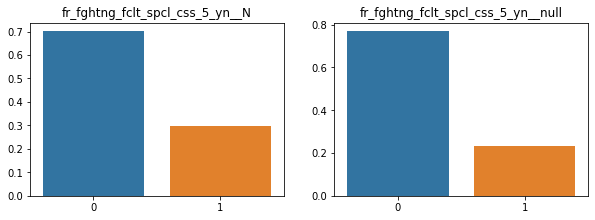

fr_fghtng_fclt_spcl_css_5_yn  : 0.29813084112149535 0.2304753171328137


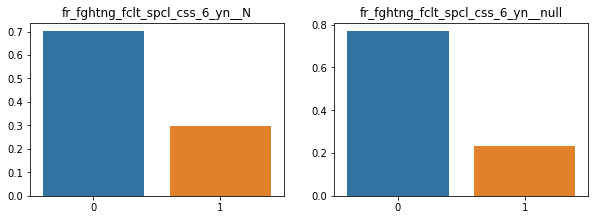

fr_fghtng_fclt_spcl_css_6_yn  : 0.29813084112149535 0.2304753171328137


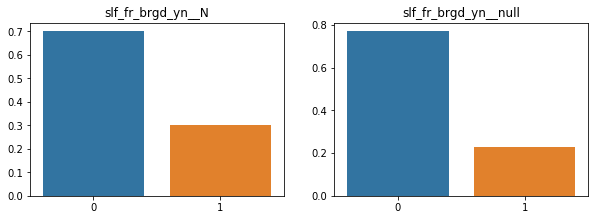

slf_fr_brgd_yn  : 0.2994350282485876 0.2278990800331662


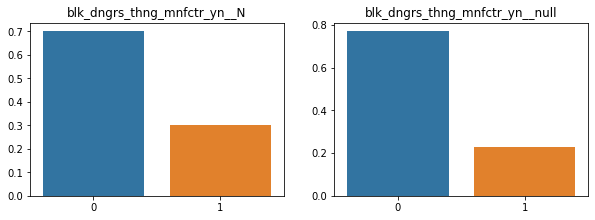

blk_dngrs_thng_mnfctr_yn  : 0.2994350282485876 0.2278990800331662


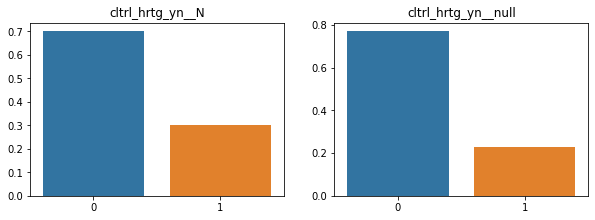

cltrl_hrtg_yn  : 0.2994350282485876 0.2278990800331662


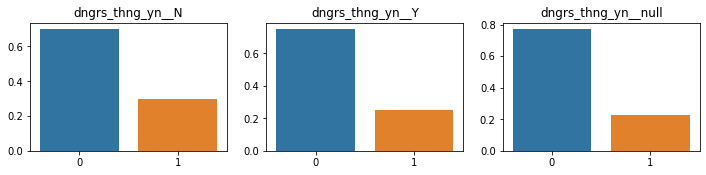

dngrs_thng_yn  : 0.29946696817961554 0.25 0.2278990800331662


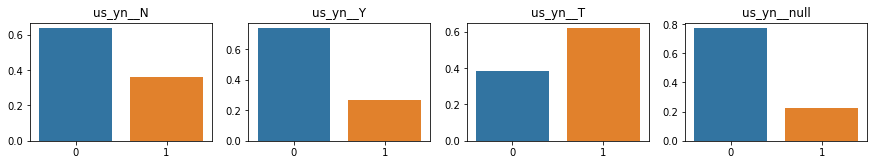

us_yn  : 0.36253041362530414 0.26385542168674697 0.6183206106870229 0.2278990800331662


In [0]:
unique_value_target(col_list)

타겟 비율이 같은 변수들
- 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn': 1개 제거
  > 

- 'slf_fr_brgd_yn','blk_dngrs_thng_mnfctr_yn','cltrl_hrtg_yn': 2개 제거


In [0]:
# 변수 제거
train = train.drop(['fr_fghtng_fclt_spcl_css_5_yn','slf_fr_brgd_yn','blk_dngrs_thng_mnfctr_yn'], axis=1)
valid = valid.drop(['fr_fghtng_fclt_spcl_css_5_yn','slf_fr_brgd_yn','blk_dngrs_thng_mnfctr_yn'], axis=1)
test = test.drop(['fr_fghtng_fclt_spcl_css_5_yn','slf_fr_brgd_yn','blk_dngrs_thng_mnfctr_yn'], axis=1)

## end_nm

In [0]:
# train: 김해시 제외한 경상남도 정보
# valid,test: 김해시

train[train['emd_nm'].isna()==False].loc[train[train['emd_nm'].isna()==False]['emd_nm'].str.contains('경상남도 김해시')]

- train은 김해시 지역명이 없으므로 제거

# 2. Numerical Features

In [0]:
# 연속형 변수 설명
codebook.loc[codebook['테이블'].isin(numeric_col)]

,테이블,출제 데이터,Unnamed: 2
1,id,아이디(분석에 미사용),132
6,bldng_cnt,건물채수,4
7,bldng_ar,건물건축면적,130.845
8,ttl_ar,건물연면적(건물층별합계전체 면적),130.845
9,lnd_ar,토지면적,390
11,ttl_grnd_flr,건물들의 지상 층수의 합,4
14,tmprtr,온도(c),4.4
15,prcpttn,강수량,1.1
16,wnd_spd,풍속,2.2
17,wnd_drctn,풍향,270


In [0]:
# 결측치 확인
numeric_null = pd.DataFrame(columns=['feature','train','valid','test'])
numeric_null['feature'] = (train[numeric_col].isna().sum() / train.shape[0]).reset_index()['index']
numeric_null['train'] = (train[numeric_col].isna().sum() / train.shape[0]).reset_index()[0]
numeric_null['valid'] = (valid[numeric_col].isna().sum() / valid.shape[0]).reset_index()[0]
numeric_null['test'] = (test[numeric_col].isna().sum() / test.shape[0]).reset_index()[0]
numeric_null[numeric_null['train']!=numeric_null['train'].iloc[0]].sort_values(by=['train']).head(50)

,feature,train,valid,test
158,ttl_ar,0.000000,0.000000,0.000000
95,cctv_dstnc,0.000000,0.000000,0.000000
44,bldng_ar,0.000000,0.000000,0.000000
43,ahsm_dstnc,0.000000,0.000000,0.000000
42,tbc_rtl_str_dstnc,0.000000,0.000000,0.000000
128,id,0.000000,0.000000,0.000000
37,fr_wthr_fclt_dstnc,0.000000,0.000000,0.000000
72,bldng_cnt_in_50m,0.000000,0.000000,0.000000
138,sft_emrgnc_bll_dstnc,0.000000,0.000000,0.000000
30,bldng_cnt,0.000000,0.000000,0.000000


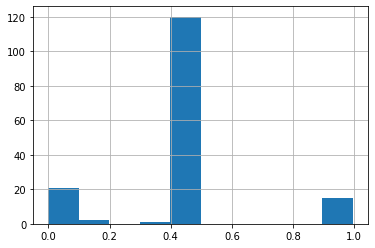

In [0]:
# 그래프로 결측 비율 분포 확인
(train[numeric_col].isna().sum() / train.shape[0]).hist(bins=10)

## 2-1) 가스랑 전기 컬럼 처리

In [0]:
# 가스, 전기 컬럼명 리스트
gas_col =[]
ele_col = []
for year in ['2014', '2015','2016','2017','2018']:
  for month in range(1,12):
    if month <10:
      month = '0' + str(month)
      period = year + month
      gas = 'gas_engry_us_' + period
      ele = 'ele_engry_us_' + period
      gas_col.append(gas)
      ele_col.append(ele)
# 종속변수 추가      
gas_col.append('fr_yn')
ele_col.append('fr_yn')

**분포와 스케일 확인**

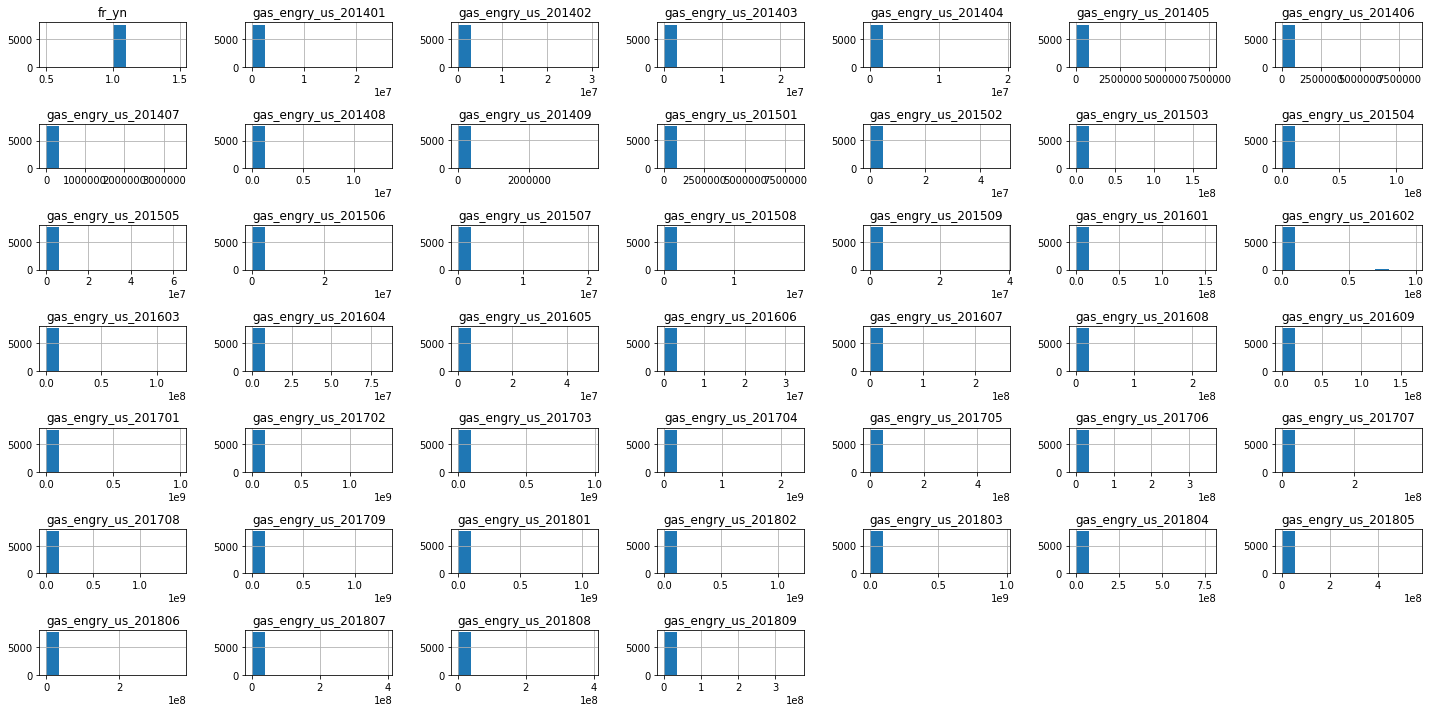

In [0]:
train[gas_col][train[gas_col]['fr_yn']==1].hist(figsize=(20,10))
plt.tight_layout()

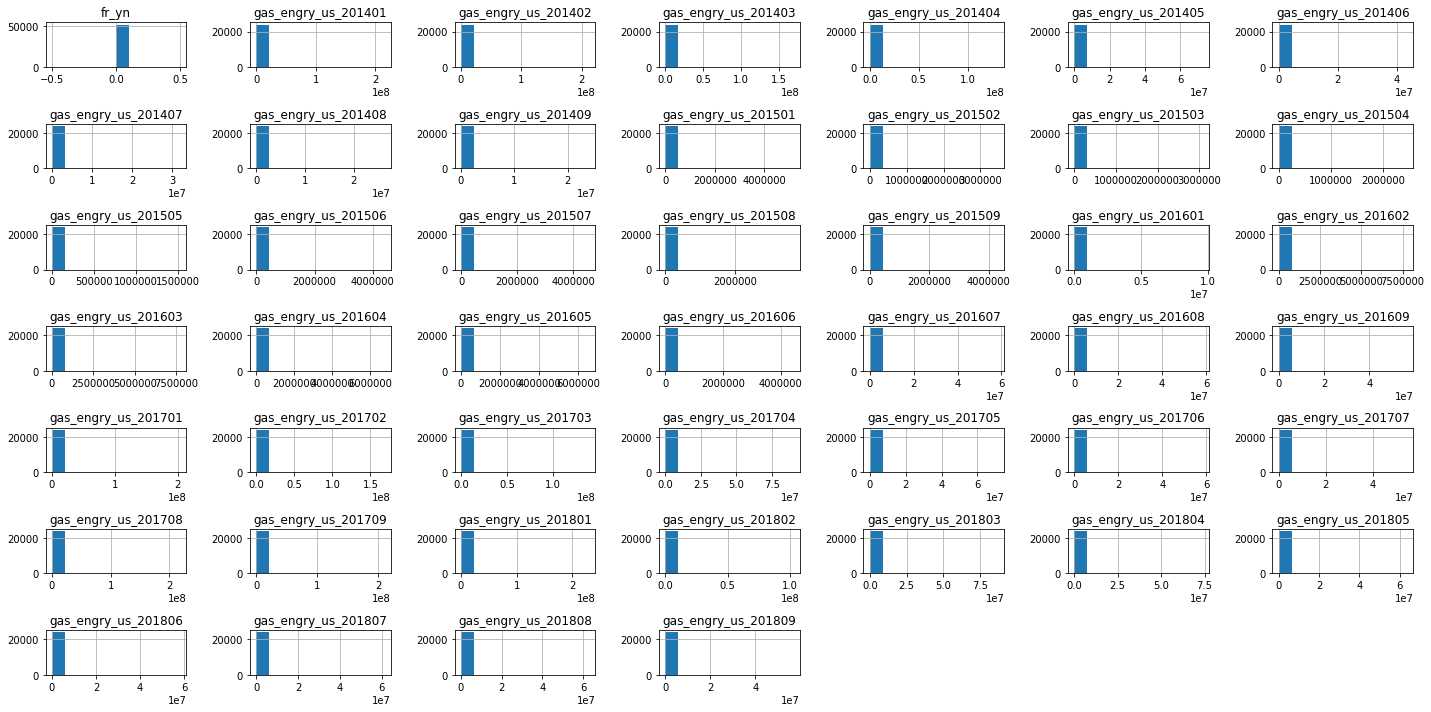

In [0]:
train[gas_col][train[gas_col]['fr_yn']==0].hist(figsize=(20,10))
plt.tight_layout()

- 분포가 매우 치우쳐있으므로(skewed) 로그 변환한다.

In [0]:
# 로그 처리
train[gas_col] = np.log(train[gas_col]+1)
train[ele_col] = np.log(train[ele_col]+1)

valid[gas_col] = np.log(valid[gas_col]+1)
valid[ele_col] = np.log(valid[ele_col]+1)

test[gas_col] = np.log(test[gas_col]+1)
test[ele_col] = np.log(test[ele_col]+1)

train['fr_yn'] = np.where(train['fr_yn']>0.5, 1, 0) # ele_col에 fr_yn이 포함되었으므로 
valid['fr_yn'] = np.where(valid['fr_yn']>0.5, 1, 0)

In [0]:
train['gas_mean'] = train[gas_col].mean(axis=1)
train['ele_mean'] = train[ele_col].mean(axis=1)

valid['gas_mean'] = valid[gas_col].mean(axis=1)
valid['ele_mean'] = valid[ele_col].mean(axis=1)

## 2-2) 'bldng_cnt', 'ttl_grnd_flr', 'ttl_dwn_flr, 'bldng_ar', 'lnd_ar'

In [0]:
# 상관관계 확인
train[['bldng_cnt','ttl_grnd_flr','ttl_dwn_flr','bldng_ar','lnd_ar']].corr()

,bldng_cnt,ttl_grnd_flr,ttl_dwn_flr,bldng_ar,lnd_ar
bldng_cnt,1.000000,0.454254,0.472871,0.530414,0.443320
ttl_grnd_flr,0.454254,1.000000,0.698330,0.350215,0.186991
ttl_dwn_flr,0.472871,0.698330,1.000000,0.422405,0.385779
bldng_ar,0.530414,0.350215,0.422405,1.000000,0.604804
lnd_ar,0.443320,0.186991,0.385779,0.604804,1.000000


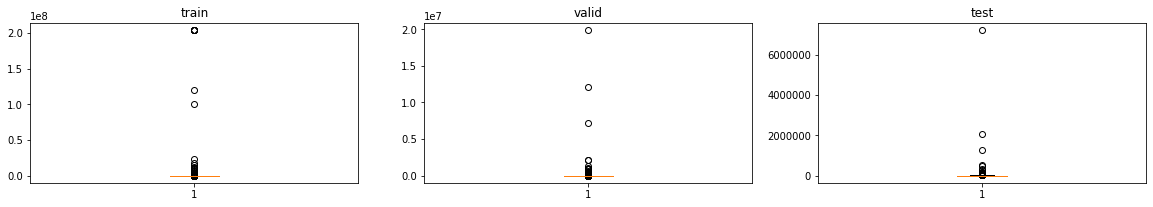

In [0]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)

ax1.boxplot(train['lnd_ar'])
ax2.boxplot(valid['lnd_ar'])
ax3.boxplot(test['lnd_ar'])

ax1.set_title('train')
ax2.set_title('valid')
ax3.set_title('test')

plt.show()

- 가스, 전기 컬럼과 마찬가지로 매우 치우쳐 있음
- train의 이상치가 상대적으로 매우 큼

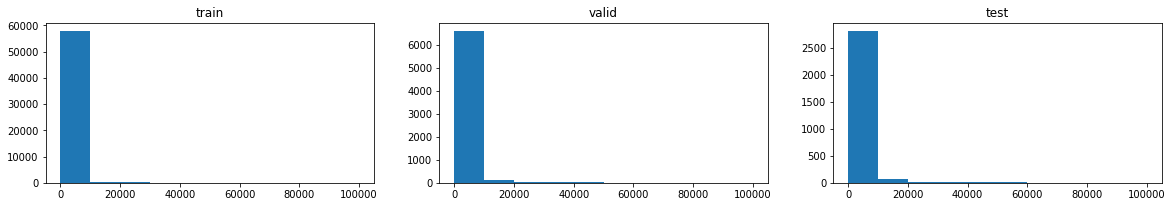

In [0]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)

ax1.hist(train['lnd_ar'], range=(0, 0.1 * 1000000))
ax2.hist(valid['lnd_ar'], range=(0, 0.1 * 1000000))
ax3.hist(test['lnd_ar'], range=(0, 0.1 * 1000000))

ax1.set_title('train')
ax2.set_title('valid')
ax3.set_title('test')

plt.show()

# 

In [0]:
null_df= train[train['bldng_us'].isna()]

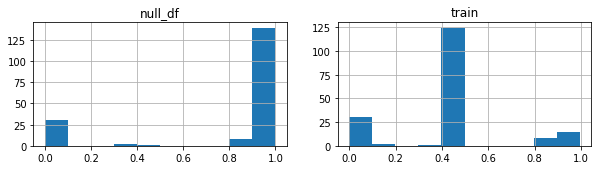

Text(0.5, 1.0, 'target')

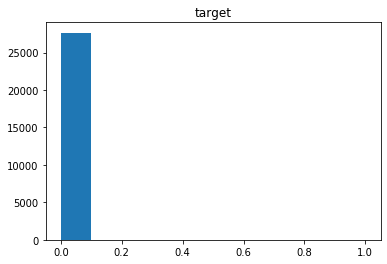

In [0]:
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
(null_df.isna().sum() / null_df.shape[0]).hist(ax=ax1, figsize=(10,5))
(train.isna().sum() / train.shape[0]).hist(ax=ax2, figsize=(10,5))
ax1.set_title('null_df')
ax2.set_title('train')
plt.show()
plt.hist(null_df['fr_yn'])
plt.title('target')

- 아까 train - test간에 결측 비율 차가 컸던 컬럼은 모두 포함됨
- 화재 발생한 건물도 전체 27677행 중에 30개 뿐이므로 모두 제거 가능

In [0]:
null_df2= valid[valid['bldng_us'].isna()]

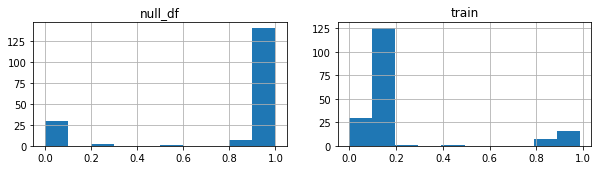

In [0]:
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
(null_df2.isna().sum() / null_df2.shape[0]).hist(ax=ax1, figsize=(10,5))
(valid.isna().sum() / valid.shape[0]).hist(ax=ax2, figsize=(10,5))
ax1.set_title('null_df')
ax2.set_title('train')
plt.show()

(array([1102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

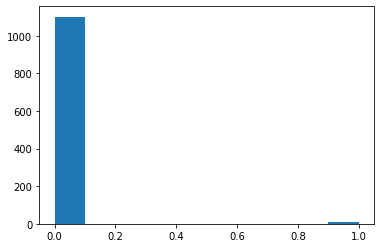

In [0]:
plt.hist(null_df2['fr_yn'])

## 다시 결측 파악

In [0]:
train = train[train['bldng_us'].isna()==False]

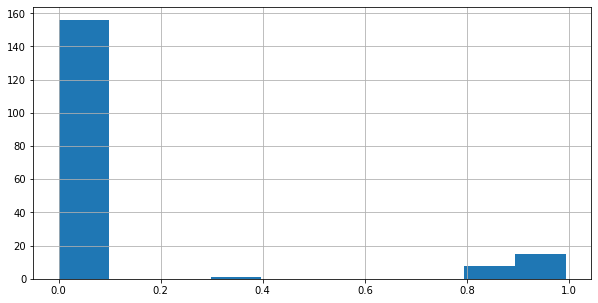

In [0]:
(train.isna().sum() / train.shape[0]).hist(figsize=(10,5))

# Baseline

In [0]:
train['prcpttn'] = train['prcpttn'].fillna(0) # 강수량 결측 = 강수량 0인 날

In [0]:
# 건축연도를 기간(연속형)으로 변경
train['dt_of_athrztn'] = train['dt_of_athrztn'].fillna(9999) # 결측치 제거
train['dt_of_athrztn'] = train['dt_of_athrztn'].astype('str').str.slice(stop=4).astype('int') # 연도만 추출
train['dt_of_athrztn'] = np.where(train['dt_of_athrztn'].astype('str').str.slice(stop=1).astype('int')>1, train['dt_of_athrztn'].astype('str').str.slice(stop=2).astype('int')+1900, train['dt_of_athrztn']) # 4자리 연도 아닌 경우 처리
train['dt_of_athrztn'] = 2019 - train['dt_of_athrztn'] # 오래된 정도로 변경
train['dt_of_athrztn'] = np.where(train['dt_of_athrztn']==-7980, np.nan, train['dt_of_athrztn']) # 결측 처리

valid['dt_of_athrztn'] = valid['dt_of_athrztn'].fillna(9999) # 결측치 제거
valid['dt_of_athrztn'] = valid['dt_of_athrztn'].astype('str').str.slice(stop=4).astype('int') # 연도만 추출
valid['dt_of_athrztn'] = np.where(valid['dt_of_athrztn'].astype('str').str.slice(stop=1).astype('int')>1, valid['dt_of_athrztn'].astype('str').str.slice(stop=2).astype('int')+1900, valid['dt_of_athrztn']) # 4자리 연도 아닌 경우 처리
valid['dt_of_athrztn'] = 2019 - valid['dt_of_athrztn'] # 오래된 정도로 변경
valid['dt_of_athrztn'] = np.where(valid['dt_of_athrztn']==-7980, np.nan, valid['dt_of_athrztn']) # 결측 처리

test['dt_of_athrztn'] = test['dt_of_athrztn'].fillna(9999) # 결측치 제거
test['dt_of_athrztn'] = test['dt_of_athrztn'].astype('str').str.slice(stop=4).astype('int') # 연도만 추출
test['dt_of_athrztn'] = np.where(test['dt_of_athrztn'].astype('str').str.slice(stop=1).astype('int')>1, test['dt_of_athrztn'].astype('str').str.slice(stop=2).astype('int')+1900, test['dt_of_athrztn']) # 4자리 연도 아닌 경우 처리
test['dt_of_athrztn'] = 2019 - test['dt_of_athrztn'] # 오래된 정도로 변경
test['dt_of_athrztn'] = np.where(test['dt_of_athrztn']==-7980, np.nan, test['dt_of_athrztn']) # 결측 처리

In [0]:
!pip install Bayesian-Optimization

  Created wheel for Bayesian-Optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=e6aae453c4ebeb0e3c6588ea44b48fd487f0b752a261443b20b980d04574bdf4
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built Bayesian-Optimization


In [0]:
# 사용할 변수와 타겟 정의
input_var = list(set(train.columns) - set(['id','dt_of_fr','fr_yn']))
target = ['fr_yn']

In [0]:
train['fr_yn'] = train['fr_yn'].astype('int')
valid['fr_yn'] = valid['fr_yn'].astype('int')

In [0]:
# LGBM 모델이 범주형 변수를 인식하도록 category 타입으로 변경
cate_col = []
for col in train[input_var].columns:
  if (train[col].dtype == 'object'):
    cate_col.append(col)

for i in enumerate (cate_col) : 
  ca = i[1] 
  train[ca] = train[ca].astype('category') 
  valid[ca] = valid[ca].astype('category')
  test[ca] = test[ca].astype('category')

In [0]:
from sklearn.metrics import f1_score
# Lgbm에서 f1 지원을 안하므로 직접 정의
def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int)
    return 'f1', f1_score(y_true, y_hat, average='weighted'), True # 향후 대회 metric에 따라 weight 없앰.

In [0]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold

# 베이지안 함수
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda,
    learning_rate,
    neg_bagging_fraction,
    pos_bagging_fraction,
    #subsample_freq
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': int(round(num_leaves)), 
              'min_data_in_leaf': int(round(min_data_in_leaf)),
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': int(round(max_depth)),
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              #'subsample_freq ': subsample_freq,
              'pos_bagging_fraction':pos_bagging_fraction,
              'neg_bagging_fraction':neg_bagging_fraction,        
              'objective': 'binary',
              'save_binary': True,
              'seed': 42,
              'feature_fraction_seed': 42,
              'bagging_seed': 42,
              'drop_seed': 42,
              'data_random_seed': 42,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': True,
              'boost_from_average': True,
              'metric':'None'}    
      

    cv_result = lgb.train(param, lgb_train,  valid_sets = [lgb_valid], verbose_eval =5000, feval= lgb_f1_score,
                       categorical_feature =cate_col) # stratified=False가 회귀, True 는 분류
    return cv_result.best_score['valid_0']['f1']

In [0]:
X_train.shape

(31522, 174)

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (1, 400), 
    'min_data_in_leaf': (100, 500),
  #  'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.01, 0.0001),
    'min_child_weight': (0.0001, 0.1),   
    'reg_alpha': (0.00001, 5), 
    'reg_lambda': (0.00001, 5),
    'max_depth':(0,174),
    #'subsample_freq ': (0.1, 0.9),
    'pos_bagging_fraction':(0,0.9999),
    'neg_bagging_fraction':(0,0.9999)

}

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 300), # 크면 오버핏
    'min_data_in_leaf': (150, 500), # 작으면 오버핏
    'bagging_fraction' : (0.0001, 0.5),
    'feature_fraction' : (0.5, 1),
 #   'learning_rate': 0.01,
    'min_child_weight': (0.0001, 0.01), # 크면 오버핏
 #   'min_split_gain': (0.001, 0.1),
    'lambda_l1': (0.00001, 5), 
    'lambda_l2': (0.00001, 5),    
    #'subsample_freq ': (0.1, 0.9),
   # 'n_estimator' : (10000.20000),

}

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time

X_train=train[input_var]
y_train=train[target]
X_train = X_train.drop(['fr_sttn_dstnc','fr_mn_cnt', 'fr_wthr_fclt_in_100m'],axis=1)
X_valid=valid[input_var]
y_valid=valid[target]
X_valid = X_valid.drop(['fr_sttn_dstnc','fr_mn_cnt', 'fr_wthr_fclt_in_100m'],axis=1)

X_test = test[input_var]
X_test = X_test.drop(['fr_sttn_dstnc','fr_mn_cnt', 'fr_wthr_fclt_in_100m'],axis=1)

# 베이지안 opt
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)
lgb_train = lgb.Dataset(X_train,label = y_train)
lgb_valid = lgb.Dataset(X_valid,label = y_valid)

init_points = 100
n_iter = 100

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)
  
params = LGB_BO.max['params']

params['num_leaves'] = int(round(params['num_leaves'])) 
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['n_estimators ']= 10000,
params['objective'] = 'binary'
params['metric'] = 'None'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | neg_ba... | num_le... | pos_ba... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7328   |  0.3996   |  0.8606   |  0.002753 |  104.2    |  0.01569  |  162.4    |  0.05808  |  346.6    |  0.6011   |  3.54     |  0.1029   |
|  2        |  0.7648   |  0.8759   |  0.766    |  0.007898 |  31.64    |  0.01842  |  221.7    |  0.5247   |  173.3    |  0.2912   |  3.059    |  0.6975   |
|  3        |  0.8058   |  0.3337   |  0.3931   |  0.005485 |  136.6    |  0.02005  |  305.7    |  0.5924   |  19.53    |  0.6075   |  0.8526   |  0.3253   |
|  4        |  0.7328   |  0.8591   |  0.8725   |  0.001997 |  53.0     |  0.00

LightGBMError: ignored

In [0]:
params = LGB_BO.max['params']

params['num_leaves'] = int(round(params['num_leaves'])) 
params['max_depth'] = int(round(params['max_depth'])) 
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['n_estimators ']= 10000,
params['objective'] = 'binary'
params['metric'] = 'None',
params['is_unbalance'] = True,
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

In [0]:
params = {'bagging_fraction': 0.2905699849522282,
 'feature_fraction': 0.5640049436665598,
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_weight': 0.0001462051986391895,
 'min_data_in_leaf': 13,
 'neg_bagging_fraction': 0.9803878600118235,
 'num_leaves': 799,
 'pos_bagging_fraction': 0.4873081206682075,
 'reg_alpha': 0.2899933980319331,
 'reg_lambda':1.8674148568255589,
 'is_unbalance': True}

params['objective'] = 'binary'
params['metric'] = 'None'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47
params['class_weight'] = 'balanced'

In [0]:
lgb_train = lgb.Dataset(X_train,
                           label = y_train
                           )
lgb_valid = lgb.Dataset(X_valid,
                           label = y_valid
                           )
clf = lgb.train(params, lgb_train, 10000, valid_sets = [lgb_valid], feval= lgb_f1_score,
                         verbose_eval=200, early_stopping_rounds = 500,categorical_feature =cate_col)

Training until validation scores don't improve for 500 rounds.
[200]	valid_0's f1: 0.707939
[400]	valid_0's f1: 0.647963
Early stopping, best iteration is:
[96]	valid_0's f1: 0.820517


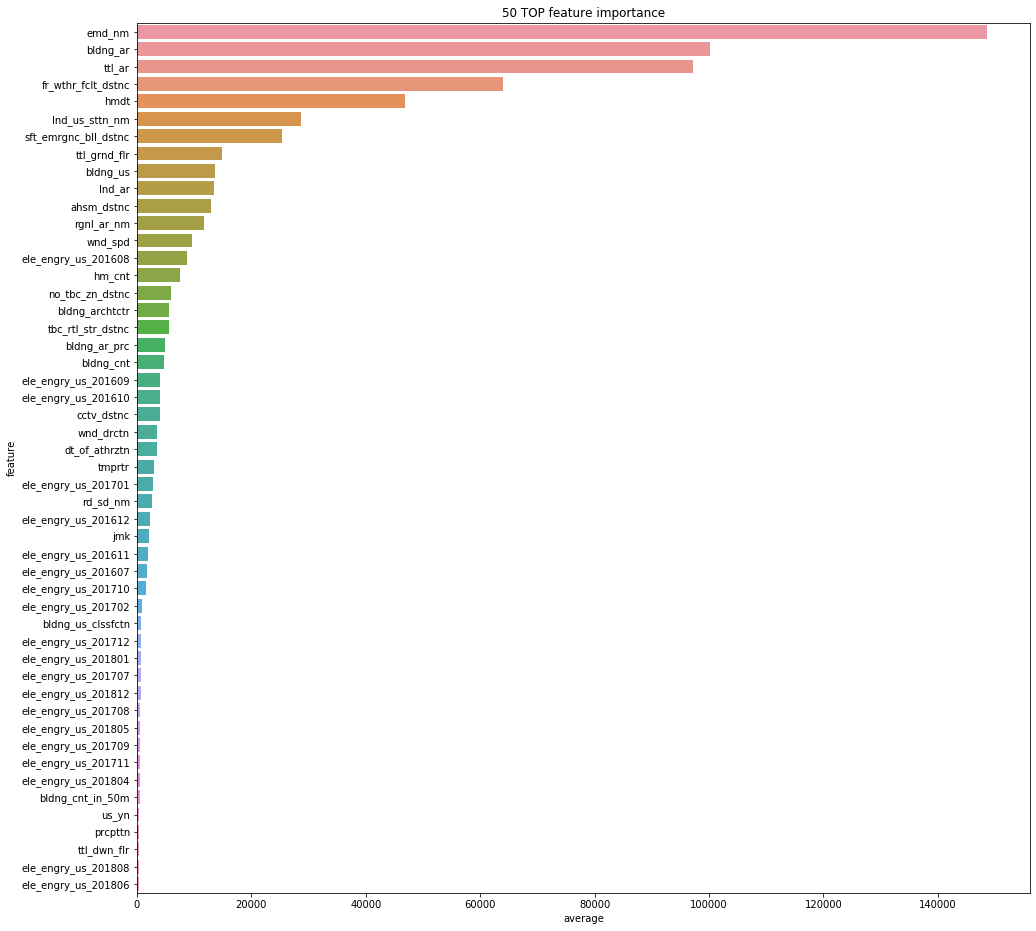

In [0]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

feature_importances['fold_{}'.format(1)] = clf.feature_importance(importance_type='gain')
feature_importances['average'] = feature_importances[['fold_{}'.format(1) for fold in range(1)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance');

In [0]:
submission['fr_yn'] = clf.predict(test[input_var])
submission['fr_yn'] = np.where(submission['fr_yn']>=0.5, 'Y', 'N')

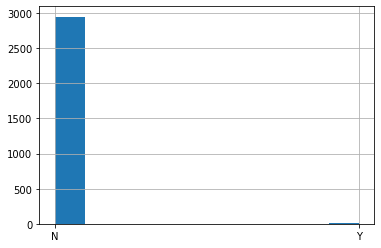

In [0]:
submission['fr_yn'].hist()

In [0]:
submission.to_csv('/content/drive/My Drive/화재예측/baseline_화재.csv', index=False)

# 적대 검증
https://www.kaggle.com/somnambwl/automatic-adversarial-validation
- train은 경상남도 전체 데이터고 valid, test는 김해시 데이터이므로 분포 차이가 분명한 변수 존재

- 적대 검증을 통해 그러한 변수를 찾아내고, 예측에 중요하지 않으면 제거하고자 함

In [0]:
ad_test = pd.concat([valid,test], axis=0).drop('fr_yn', axis=1)
ad_test['ad'] = 1

ad_train = train.drop('fr_yn', axis=1)
ad_train['ad'] = 0

ad_train = pd.concat([ad_train,ad_test], axis=0)

In [0]:
input_var = list(set(ad_train.columns) - set(['id','dt_of_fr','ad']))
target = ['ad']

In [0]:
ad_train['dt_of_athrztn'] = ad_train['dt_of_athrztn'].fillna(9999) # 결측치 제거
ad_train['dt_of_athrztn'] = ad_train['dt_of_athrztn'].astype('str').str.slice(stop=4).astype('int') # 연도만 추출
ad_train['dt_of_athrztn'] = np.where(ad_train['dt_of_athrztn'].astype('str').str.slice(stop=1).astype('int')>1, ad_train['dt_of_athrztn'].astype('str').str.slice(stop=2).astype('int')+1900, ad_train['dt_of_athrztn']) # 4자리 연도 아닌 경우 처리
ad_train['dt_of_athrztn'] = 2019 - ad_train['dt_of_athrztn'] # 오래된 정도로 변경
ad_train['dt_of_athrztn'] = np.where(ad_train['dt_of_athrztn']==-7980, np.nan, ad_train['dt_of_athrztn']) # 결측 처리

In [0]:
ad_train = ad_train.drop(['id','dt_of_fr'],axis=1)

In [0]:
cate_col = []
for col in ad_train[input_var].columns:
  if (ad_train[col].dtype == 'object'):
    cate_col.append(col)

for i in enumerate (cate_col) : 
  ca = i[1] 
  ad_train[ca] = ad_train[ca].astype('category') 

In [0]:
params = {'bagging_fraction': 0.2905699849522282,
 'feature_fraction': 0.5640049436665598,
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_weight': 0.0001462051986391895,
 'min_data_in_leaf': 13,
 'neg_bagging_fraction': 0.9803878600118235,
 'num_leaves': 799,
 'pos_bagging_fraction': 0.4873081206682075,
 'reg_alpha': 0.2899933980319331,
 'reg_lambda':1.8674148568255589,
 'use_missing': True,
 'is_unbalance': True}

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47


n_estimators = 1000                                                                                                                                                       
verbose = 1000                                                                                                                                                             
early_stopping_rounds = 200 

In [0]:
# 제거하는 컬럼 리스트
drop_columns = list()
dropped_values = list()
CVs = list()
drop_max_columns = -1   # -1 is for: repeat until all but one columns are dropped
dset = ad_train # dset으로 원본 코드에 맞게 이름 변경
thing_to_learn = "ad"

if drop_max_columns == -1:
    drop_max_columns = dset.shape[1] - 1
if drop_max_columns > dset.shape[1]:
    drop_max_columns = dset.shape[1] - 1

In [0]:
from time import time
N_folds = 5
cate_col2 = cate_col.copy() # 카테고르 변수 리스트 복사
dropped_already = -1

allowed_time = 7.5 * 60 * 60 * 60
start_time = time()
current_time = time()
while dropped_already < drop_max_columns and (current_time - start_time) < allowed_time:
    CV = 0
    feature_importance = pd.DataFrame() 
    kf = KFold(n_splits=N_folds, random_state=312, shuffle=True)
    fold_n = 0
    for i,(train_index, valid_index) in enumerate(kf.split(dset)):
        X_train, X_valid = dset.drop([thing_to_learn]+drop_columns, axis=1).iloc[train_index], dset.drop([thing_to_learn]+drop_columns, axis=1).iloc[valid_index]
        y_train, y_valid = dset[thing_to_learn].iloc[train_index], dset[thing_to_learn].iloc[valid_index]
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)
        model = lgb.train(params, dtrain, n_estimators, valid_sets=[dtrain, dvalid], verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds ,categorical_feature =cate_col2)
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = dset.drop([thing_to_learn]+drop_columns, axis=1).columns                                                                                                                                     
        fold_importance["importance"] = model.feature_importance()                                                                                                              
        fold_importance["fold"] = fold_n + 1                  
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)                                                                                        
        CV += model.best_score["valid_1"]["auc"] 
        fold_n += 1
    CV /= N_folds
    print('*************** Mean AUC:', CV, ', ', X_train.shape)
    
    # 결과 저장
    fi = pd.DataFrame({"Feature":feature_importance.pivot(index="fold", columns="feature", values="importance").columns.values,                                   
                      "Value":feature_importance.pivot(index="fold", columns="feature", values="importance").mean().values})
    row = fi.iloc[fi['Value'].idxmax()]
    feature = row["Feature"]
    value = row["Value"]
    drop_columns.append(feature)
    if feature in cate_col2: # 카테고리 변수 리스트도 업데이트
      cate_col2.remove(feature)
    dropped_values.append(value)
    CVs.append(CV)
    dropped_already += 1
    current_time = time()

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.999937	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.999937	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 0.999749
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.999937	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.999937	valid_1's auc: 1
*************** Mean AUC: 0.9999497991967872 ,  (55244, 174)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[4]	training's auc: 1	valid_1's auc: 1
Training until validation scores don't improve for 200 rounds.
Early stopping, bes

ValueError: ignored

In [0]:
drop_columns = drop_columns[:-1]
dropped_values = dropped_values[:-1]
drop_columns.insert(0, "Nothing")
dropped_values.insert(0, 0)
deltas = list(np.array(CVs)[:-1] - np.array(CVs)[1:])
deltas.insert(0, 0)
df = pd.DataFrame({"Dropped_feature":drop_columns, "CV_change":deltas, "N_dropped":np.arange(len(CVs)), "CV":CVs})
df.to_csv("/content/drive/My Drive/화재예측/adver_cv_Results.csv")
df

In [0]:
df.head(50)

,Dropped_feature,CV_change,N_dropped,CV
0,Nothing,0.000000e+00,0,0.999950
1,emd_nm,-4.898603e-05,1,0.999999
2,ahsm_dstnc,3.663476e-08,2,0.999999
3,hm_cnt,-1.242800e-06,3,1.000000
4,bldng_ar_prc,2.315049e-06,4,0.999998
5,no_tbc_zn_dstnc,7.362241e-08,5,0.999998
6,cctv_dstnc,3.460025e-07,6,0.999997
7,sft_emrgnc_bll_dstnc,2.292654e-06,7,0.999995
8,tbc_rtl_str_dstnc,-1.369283e-06,8,0.999996
9,tmprtr,-3.334548e-06,9,1.000000


In [0]:
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.plotting import figure, show

output_notebook()

fig = figure(plot_height=700,
             plot_width=900,
             x_axis_label='Number of dropped features',
             x_range=(0, drop_max_columns),
             y_axis_label='AUC',
             title='AUC vs number of dropped features',
             toolbar_location='below',
             tools='save, box_zoom, pan, wheel_zoom, reset')

tooltips = [
            ('Dropped feature','@Dropped_feature'),
            ('CV change', '@CV_change'),
            ("Number of dropped features", "@N_dropped"),
            ("Current CV", "@CV")
           ]

scatter = fig.circle(x='N_dropped', y='CV', source=df,
        size=15, alpha=1,
        hover_fill_color='cyan', hover_alpha=0.3)

fig.add_tools(HoverTool(tooltips=tooltips, renderers=[scatter]))

show(fig)

- AUC 0.8을 기준으로 변수 제거 혹은 변형을 고려
- 99%대 변수를 1군집, 80%대 변수를 2군집으로 정의

# 적대검증 변수 중요도 상위권부터 처리
 - 안타깝게도, 적대검증에서 분포 차이가 크다고 밝혀진 변수들이 화재 예측에도 중요한 변수들이었다.
 - 그래서 제거는 하지 못하고, 범주형으로 변경하는 등의 변형을 시도했다.

1군집: 

['emd_nm', 'ahsm_dstnc', 'hm_cnt', 'bldng_ar_prc', 'no_tbc_zn_dstnc', 'cctv_dstnc', 'sft_emrgnc_bll_dstnc', 
'tbc_rtl_str_dstnc', 'tmprtr', 'fr_mn_cnt', 'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'hmdt', 'wnd_spd', 'ttl_ar', 'bldng_ar', 
'lnd_ar', 'dt_of_athrztn', 'wnd_drctn', 'bldng_cnt_in_50m', 'bldng_cnt', 'ttl_grnd_flr']


2군집

['prcpttn', 'cctv_in_100m', 'ttl_dwn_flr', 'fr_wthr_fclt_in_100m', 'us_yn', 'rd_sd_nm', 
'fr_fghtng_fclt_spcl_css_6_yn', 'rgnl_ar_nm', 'lnd_us_sttn_nm', 'jmk', 'bldng_us' , 'bldng_us_clssfctn'

'ele_engry_us_201609', 'ele_engry_us_201608', 'ele_engry_us_201607', 'ele_engry_us_201610', 'ele_engry_us_201611', 
'ele_engry_us_201612', 'ele_engry_us_201701', 'ele_engry_us_201702', 'ele_engry_us_201703', 'ele_engry_us_201704', 
'ele_engry_us_201705', 'ele_engry_us_201706', 'ele_engry_us_201812', 'ele_engry_us_201707', 'ele_engry_us_201708', 
'ele_engry_us_201711', 'ele_engry_us_201709', 'ele_engry_us_201710', 'ele_engry_us_201712', 'ele_engry_us_201801', 
'ele_engry_us_201808', 'ele_engry_us_201802', 'ele_engry_us_201803', 'ele_engry_us_201804', 'ele_engry_us_201805', 
'ele_engry_us_201806', 'ele_engry_us_201809', 'ele_engry_us_201810', 'ele_engry_us_201807', 'ele_engry_us_201811']

### emd_nm

In [0]:
# 'emd_nm'
train['emd_nm2'] = train['emd_nm'].str.slice(start=5, stop=8).str.slice(start=-1)
train['emd_nm3'] = train['emd_nm'].str.slice(start=-1)
train['emd_nm3'] = np.where(train['emd_nm3']=='가', '동', train['emd_nm3']) # ~동 ~가는 동으로 변경

valid['emd_nm2'] = valid['emd_nm'].str.slice(start=5, stop=8).str.slice(start=-1)
valid['emd_nm3'] = valid['emd_nm'].str.slice(start=-1)
test['emd_nm2'] = test['emd_nm'].str.slice(start=5, stop=8).str.slice(start=-1)
test['emd_nm3'] = test['emd_nm'].str.slice(start=-1)

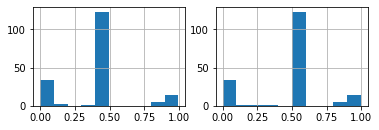

In [0]:
# 시,군 결측치 차이는 없네
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
(train[train['emd_nm2']=='시'].isna().sum() / train[train['emd_nm2']=='시'].shape[0]).hist(ax=ax1)
(train[train['emd_nm2']=='군'].isna().sum() / train[train['emd_nm2']=='군'].shape[0]).hist(ax=ax2)

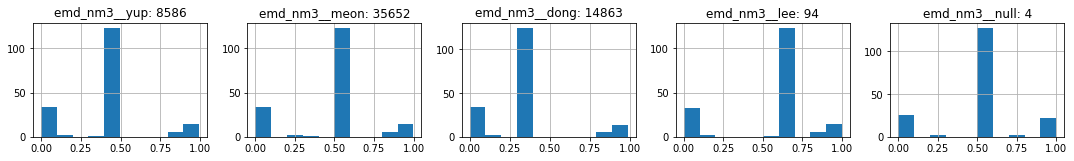

In [0]:
# 읍면동리는?
plt.figure(figsize=(15,10))
ax1 = plt.subplot(5,5,1)
ax2 = plt.subplot(5,5,2)
ax3 = plt.subplot(5,5,3)
ax4 = plt.subplot(5,5,4)
ax5 = plt.subplot(5,5,5)
col = 'emd_nm3'
(train[train[col]=='읍'].isna().sum() / train[train[col]=='읍'].shape[0]).hist(ax=ax1)
(train[train[col]=='면'].isna().sum() / train[train[col]=='면'].shape[0]).hist(ax=ax2)
(train[train[col]=='동'].isna().sum() / train[train[col]=='동'].shape[0]).hist(ax=ax3)
(train[train[col]=='리'].isna().sum() / train[train[col]=='리'].shape[0]).hist(ax=ax4)
(train[train[col].isna()].isna().sum() / train[train[col].isna()].shape[0]).hist(ax=ax5)

ax1.set_title(col + '__yup'+ ': '+str(train[train[col]=='읍'].shape[0]))
ax2.set_title(col + '__meon'+ ': '+str(train[train[col]=='면'].shape[0]))
ax3.set_title(col + '__dong'+ ': '+str(train[train[col]=='동'].shape[0]))
ax4.set_title(col + '__lee'+ ': '+str(train[train[col]=='리'].shape[0]))
ax5.set_title(col + '__null'+ ': '+str(train[train[col].isna()].shape[0]))

plt.tight_layout()

- test에는 '리'와 결측이 없는데 train에 98개 밖에 없으므로 지우자!!

In [0]:
train = train[(train['emd_nm3']!='리') & (train['emd_nm3'].isna()==False)]

### ahsm_dstnc: 자동 심장 충격기와의 최소거리

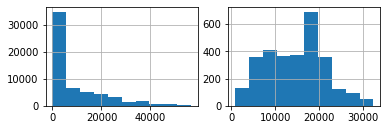

In [0]:
# ahsm_dstnc
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
train['ahsm_dstnc'].hist(ax=ax1)
test['ahsm_dstnc'].hist(ax=ax2) 

- 분포가 너무 다른데 방법이 없으니 지워야?

### hm_cnt: 행정구역 인구

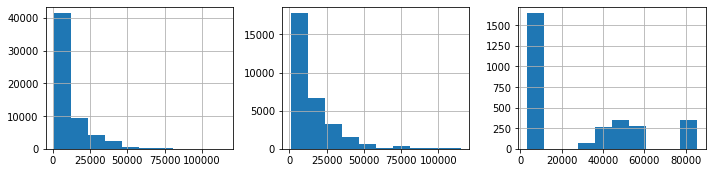

In [0]:
plt.figure(figsize=(10,7))

ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)
train['hm_cnt'].hist(ax=ax1)
train[train['emd_nm2']=='시']['hm_cnt'].hist(ax=ax2)
test['hm_cnt'].hist(ax=ax3) 
plt.tight_layout()

- 없앨수는 없고 log 변환으로 모아주자

In [0]:
train['hm_cnt']

###  'bldng_ar_prc': 단위 면적당 건물 가격

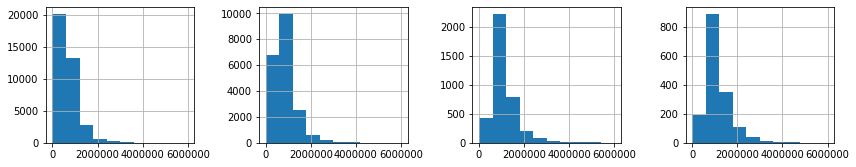

In [0]:
# train[train['emd_nm2']=='시']
plt.figure(figsize=(12,9))
ax1 = plt.subplot(4,4,1)
ax2 = plt.subplot(4,4,2)
ax3 = plt.subplot(4,4,3)
ax4 = plt.subplot(4,4,4)
train['bldng_ar_prc'].hist(ax=ax1, range=(0,6000000))
train[train['emd_nm2']=='시']['bldng_ar_prc'].hist(ax=ax2, range=(0,6000000))
valid['bldng_ar_prc'].hist(ax=ax3, range=(0,6000000))
test['bldng_ar_prc'].hist(ax=ax4, range=(0,6000000)) 
plt.tight_layout()

### 'no_tbc_zn_dstnc: 금연구역과의 최소 거리



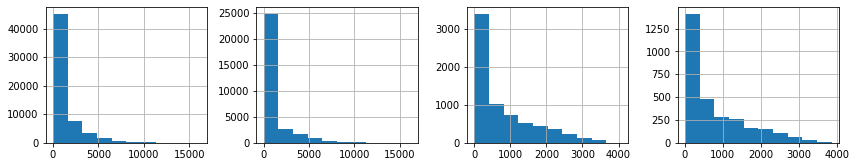

In [0]:
col = 'no_tbc_zn_dstnc'
plt.figure(figsize=(12,9))
ax1 = plt.subplot(4,4,1)
ax2 = plt.subplot(4,4,2)
ax3 = plt.subplot(4,4,3)
ax4 = plt.subplot(4,4,4)
train[col].hist(ax=ax1)
train[train['emd_nm2']=='시'][col].hist(ax=ax2)
valid[col].hist(ax=ax3)
test[col].hist(ax=ax4) 
plt.tight_layout()

### fr_me_cnt: 관할 소방서 인원

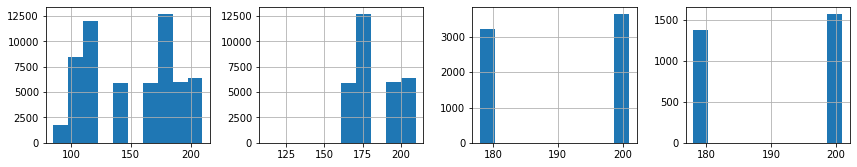

In [0]:
#'fr_mn_cnt' 이건 제거!
col = 'fr_mn_cnt'
plt.figure(figsize=(12,9))
ax1 = plt.subplot(4,4,1)
ax2 = plt.subplot(4,4,2)
ax3 = plt.subplot(4,4,3)
ax4 = plt.subplot(4,4,4)
train[col].hist(ax=ax1)
train[train['emd_nm2']=='시'][col].hist(ax=ax2)
valid[col].hist(ax=ax3)
test[col].hist(ax=ax4) 
plt.tight_layout()

- 김해시에는 서부,동부 소방서 2개만 있음
- 따라서 제거

### bldng_cnt: 건물채수

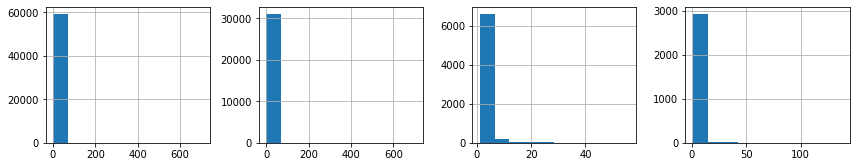

In [0]:
#'bldng_cnt'
col = 'bldng_cnt'
plt.figure(figsize=(12,9))
ax1 = plt.subplot(4,4,1)
ax2 = plt.subplot(4,4,2)
ax3 = plt.subplot(4,4,3)
ax4 = plt.subplot(4,4,4)
train[col].hist(ax=ax1)
train[train['emd_nm2']=='시'][col].hist(ax=ax2)
valid[col].hist(ax=ax3)
test[col].hist(ax=ax4) 
plt.tight_layout()

### dt_of_athrztn: 건축승인일자

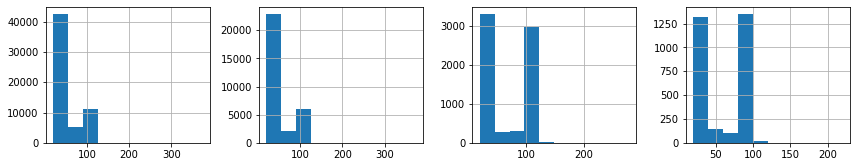

In [0]:
#'bldng_cnt'
col = 'dt_of_athrztn'
plt.figure(figsize=(12,9))
ax1 = plt.subplot(4,4,1)
ax2 = plt.subplot(4,4,2)
ax3 = plt.subplot(4,4,3)
ax4 = plt.subplot(4,4,4)
train[col].hist(ax=ax1)
train[train['emd_nm2']=='시'][col].hist(ax=ax2)
valid[col].hist(ax=ax3)
test[col].hist(ax=ax4) 
plt.tight_layout()

### 거리 같은 연속형 변수들의 범주화 가능성 확인

In [0]:
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier


# tree 시각화 코드
def draw_decision_tree(model):
    dot_buf = io.StringIO()
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0]
    image = graph.create_png()
    return Image(image)

In [0]:
# 로그변환 할 컬럼 리스트

log_col = ['ahsm_dstnc', 'hm_cnt', 'bldng_ar_prc', 'no_tbc_zn_dstnc', 'cctv_dstnc', 'sft_emrgnc_bll_dstnc', 'tbc_rtl_str_dstnc', 
 'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'ttl_ar', 'bldng_ar', 'lnd_ar','bldng_cnt']

for col in log_col:
  col2 = 'ln_'+ col

  # 로그 변환
  train[col2] = np.log(train[col]+1)
  valid[col2] = np.log(valid[col]+1)
  test[col2] = np.log(test[col]+1)

  # 의사결정나무
  X2 = valid[[col,'fr_yn']].dropna(axis=0) # test와 분포가 비슷한 valid에 의사결정나무 적용
  y2 = X2['fr_yn']
  X2 = np.log(X2[[col]]+1)

  feature_names =[ X2.columns[0]]
  class_names=['fr_yn']
  tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0).fit(X2, y2)
  # 범주화
  thresh = tree2.tree_.threshold
  train[col2] = np.where(train[col2]<=thresh[0], 
                        np.where((train[col2]>=thresh[1]) & (train[col2]<=thresh[0]), 1, 0),
                        np.where((train[col2]>thresh[0]) & (train[col2]<=thresh[4]), 2, 3)
                        )
  valid[col2] = np.where(valid[col2]<=thresh[0], 
                        np.where((valid[col2]>=thresh[1]) & (valid[col2]<=thresh[0]), 1, 0),
                        np.where((valid[col2]>thresh[0]) & (valid[col2]<=thresh[4]), 2, 3)
                        )
  test[col2] = np.where(test[col2]<=thresh[0], 
                        np.where((test[col2]>=thresh[1]) & (test[col2]<=thresh[0]), 1, 0),
                        np.where((test[col2]>thresh[0]) & (test[col2]<=thresh[4]), 2, 3)
                        )
  train[col2] = train[col2].astype('object')
  valid[col2] = valid[col2].astype('object')
  test[col2] = test[col2].astype('object')

- 로그변환만으로는 적대 검증에 변화가 없었다. 범주화가 마지막 방법이다. 
- 로그변환 후, valid의 fr_yn을 타겟으로 결정나무 깊이=2로 하여  4개 범주로 구분하였다. 
  -> test와 같은 기준으로 타겟을 나누기 위함

(관련링크: https://m.blog.naver.com/PostView.nhn?blogId=tjsqjavmfh&logNo=220865426481&proxyReferer=https%3A%2F%2Fwww.google.com%2F)

  
 - 범주의 병합/연속형 변수의 이산화

      : 범주형 목표변수의 범주를 더 적은 수로 병합하거나 연속형 목표변수를 몇개         등급으로 범주화하고자 하는 경우 의사결정나무를 활용

**결론**

- 범주형 변수로 변경 후에 예측한 결과 f1 score가 10% 이상 떨어졌다. 

- feature importance가 높은 변수를 범주화 하면서 많은 정보를 잃었기 때문

      ==> 이 방법은 쓰지 않고, Validation 전략을 고민하기로 했다.